In [87]:
import subprocess
import sympy as sp
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import csv
from enum import Enum
from itertools import cycle
%matplotlib inline

# restore some of the defaults that I believe are changed by the inline magic
mpl.rcParams.update(mpl.rcParamsDefault)

from matplotlib import rcParams
rcParams['font.size'] = 17
rcParams['figure.figsize'] = [15, 15]

# Small font size for the legend
from matplotlib.font_manager import FontProperties
fontP = FontProperties()
fontP.set_size('x-small')


In [2]:
def get_last_row(csv_filename):
    '''
    Function which returns just the last row of a CSV file.  We have to
    read every line of the file, there was no stackoverflow example of
    reading just the last line.
    http://stackoverflow.com/questions/20296955/reading-last-row-from-csv-file-python-error
    '''
    with open(csv_filename, 'r') as f:
        lastrow = None
        for row in csv.reader(f):
            if (row != []): # skip blank lines at end of file.
                lastrow = row
        return lastrow


In [67]:
class ResidualType(Enum):
    TIME = 1
    NON_TIME = 2

In [93]:
class SUPGSim(object):
    def __init__(self, include_transient_term, residual_type=ResidualType.TIME):
        if include_transient_term:
            if residual_type is ResidualType.TIME:
                self.active_kernels = "'time adv mms_forcing_function supg time_supg'"
                self.non_time_flag = 'false'
                self.title = 'Time-trans'
            elif residual_type is ResidualType.NON_TIME:
                self.active_kernels = "'time adv mms_forcing_function supg'"
                self.non_time_flag = 'true'
                self.title = 'Non-time-trans'
        else:
            self.active_kernels = "'time adv mms_forcing_function supg'"
            self.non_time_flag = 'false'
            self.title = 'No-trans'
        

In [94]:
# Plot colors
colors = ['maroon', 'blue', 'green', 'black', 'burlywood', 'olivedrab', 'midnightblue',
          'tomato', 'darkmagenta', 'chocolate', 'lightslategray', 'skyblue']

# Plot line markers
markers = ['v', 'o', 'x', '^', 'H', 'h', '+', 'D', '*', '4', 'd', '8']

# Plot line styles
linestyles = [':', '-', '-.', '--', ':', '-.', '--', ':', '--', '-', '-.', '-']

color_cycle = cycle(colors)
marker_cycle = cycle(markers)
linestyle_cycle = cycle(linestyles)

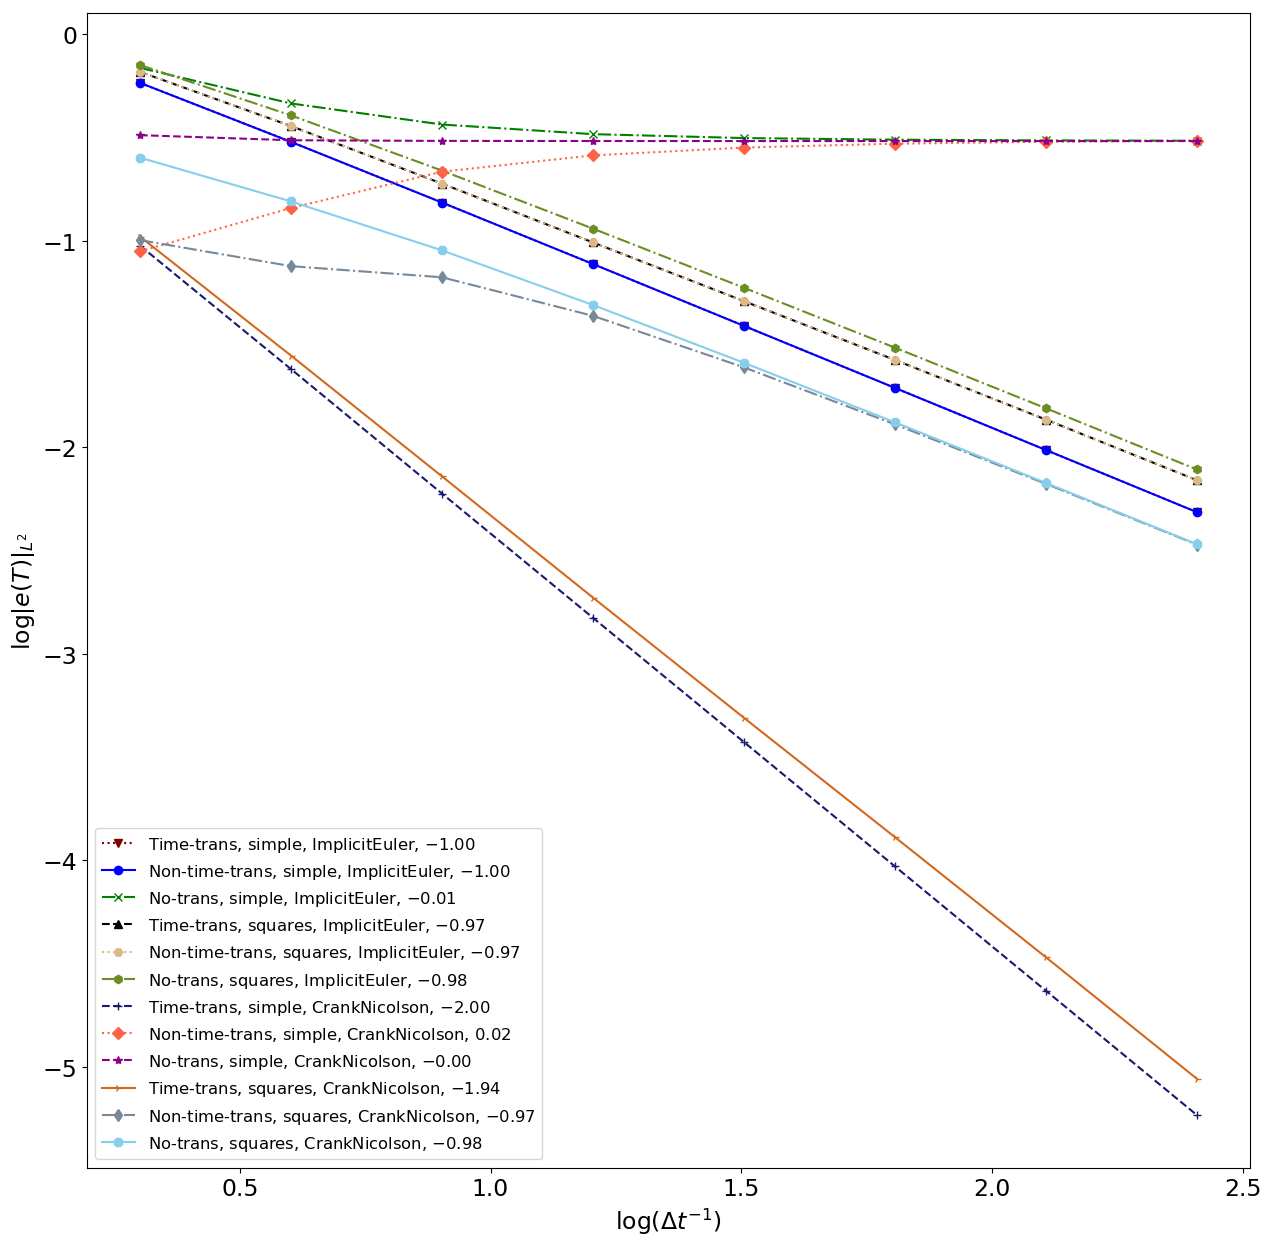

In [95]:
x, y, t = sp.symbols('x y t')

exact_soln = t**3 * (x**2 + y**2)

forcing_function = sp.diff(exact_soln,t) + \
                   sp.diff(exact_soln,x)

# Sub ** for ^ so the function parser doesn't cough
exact_soln = str(exact_soln).replace('**','^')
forcing_function = str(forcing_function).replace('**','^')

num_runs = 8
dts = np.asarray([1. / 2**i for i in range(1,num_runs+1)])

time_integrators = ['ImplicitEuler', 'CrankNicolson']

tau_schemes = ['simple', 'squares']

supg_sims = []
supg_sims.append(SUPGSim(True, ResidualType.TIME))
supg_sims.append(SUPGSim(True, ResidualType.NON_TIME))
supg_sims.append(SUPGSim(False))

colors_dict = {}
markers_dict = {}
linestyles_dict = {}

for ti in time_integrators:
    for ts in tau_schemes:
        for supg in supg_sims:
            colors_dict[(ti, ts, supg)] = next(color_cycle)
            markers_dict[(ti, ts, supg)] = next(marker_cycle)
            linestyles_dict[(ti, ts, supg)] = next(linestyle_cycle)

fig = plt.figure()
ax1 = fig.add_subplot(111)

for i in range(len(time_integrators)):
    time_integrator = time_integrators[i]
    
    for tau_scheme in tau_schemes:
        for supg in supg_sims:

            results = np.zeros(len(dts))
            for index,dt in enumerate(dts):
                args = ['../../../../navier_stokes-opt',
                        '--allow-test-objects',
                       '-i',
                       'stabilized-time-convergence-study.i',
                       'Functions/forcing_function/value=' + str(forcing_function),
                       'Functions/exact_soln/value=' + str(exact_soln),
                       'Executioner/dt=' + str(dt),
                       'Executioner/TimeIntegrator/type=' + time_integrator,
                       'GlobalParams/tau_type=' + tau_scheme,
                       "Kernels/active=" + supg.active_kernels,
                       "Kernels/supg/include_transient_term=" + supg.non_time_flag]
                subprocess.run(args)
                results[index] = get_last_row('stabilized-time-convergence-study_out.csv')[1]

            # Make plot
            xdata = np.log10(np.reciprocal(dts))
            ydata = np.log10(results)

            # Compute linear fit of last three points.
            start_fit = len(xdata) - 3
            end_fit = len(xdata)
            fit = np.polyfit(xdata[start_fit:end_fit], ydata[start_fit:end_fit], 1)

            ax1.plot(xdata, ydata, label=supg.title + ', ' + tau_scheme + ', ' + time_integrator + \
                     ", $" + "{:.2f}".format(fit[0]) + "$",
                 color=colors_dict[(time_integrator,tau_scheme,supg)], 
                     marker=markers_dict[(time_integrator,tau_scheme,supg)], 
                     linestyle=linestyles_dict[(time_integrator,tau_scheme,supg)])


# Set up the axis labels.
ax1.set_xlabel('$\log (\Delta t^{-1})$')
ax1.set_ylabel('$\log \|e(T)\|_{L^2}$')

# Add a legend
plt.legend(loc='lower left', prop=fontP)

plt.show()